In [1]:
import os.path as osp
import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GNNExplainer, GCNConv
from torch_geometric.utils import k_hop_subgraph, from_networkx
import pickle
import networkx as nx
from math import floor
from tqdm import tqdm
import seaborn as sns
from scipy.sparse import coo_matrix,csr_matrix

import sys
sys.path.append("..")

from BayesianExplainerNF import BayesianExplainer

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

prefix = '/gpfs_home/spate116/singhlab/GCN_Integration/scripts/BI/pyro_model/synthetic/'
G = nx.read_gpickle( prefix + 'data/syn3_G.pickle')
with open(prefix + 'data/syn3_lab.pickle', 'rb') as f:
    labels = pickle.load(f)

x = torch.tensor([x[1]['feat'] for x in G.nodes(data=True)])
edge_index = torch.tensor([x for x in G.edges])
edge_index_flipped = edge_index[:, [1, 0]]
edge_index = torch.cat((edge_index, edge_index_flipped))
y = torch.tensor(labels, dtype=torch.long)
data = Data(x=x, edge_index=edge_index.T, y=y)

class Net(torch.nn.Module):
    def __init__(self, x=64):
        super(Net, self).__init__()
        self.conv1 = GCNConv(10, x)
        self.conv2 = GCNConv(x, x)
        self.conv3 = GCNConv(x, x)
        self.fc = torch.nn.Linear(x, max(y).tolist()+1)

    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        return self.fc(x)
    
# Load everything onto the gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
x, edge_index = data.x, data.edge_index

model = Net(x=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_loss = 100
pbar = tqdm(range(10000))
for epoch in pbar:
    # Training step
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.cross_entropy(log_logits, data.y)
    loss.backward()
    optimizer.step()

    # Testing step
    model.eval()
    best_loss = loss if loss < best_loss else best_loss
    pbar.set_description("Acc -> %.4f" % torch.mean((torch.argmax(log_logits, dim=1) == data.y).float()).item())

Acc -> 0.9414: 100%|██████████| 10000/10000 [00:50<00:00, 199.58it/s]


Explain node 549: 100%|██████████| 1000/1000 [00:04<00:00, 206.84it/s]


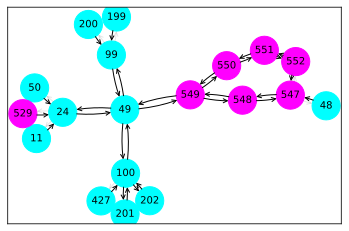

In [2]:
explainer = GNNExplainer(model, epochs=1000)
node_idx = 549
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)

Loss -> 0.0000: 100%|██████████| 5000/5000 [08:06<00:00, 10.27it/s]


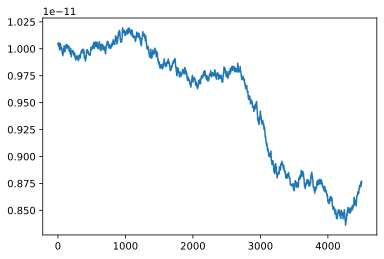

In [11]:
k = 3
sharp = 1e-12
splines = 8
explainer = BayesianExplainer(model, node_idx, k, x, edge_index, sharp, splines, sigmoid=False)
avgs = explainer.train(epochs=5000, lr=2, lambd=4e-12, window=500, p = 1.25, log=True)
sns.lineplot(x = range(len(avgs)), y = avgs)

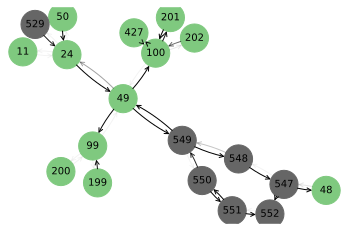

In [12]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, data.y, k)
plt.show()

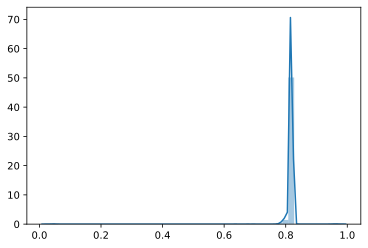

In [13]:
sns.distplot(explainer.flow_dist.rsample(torch.Size([10000,])).sigmoid()[:, 7].detach().numpy())

In [14]:
explainer.p

Parameter containing:
tensor(1.2513, requires_grad=True)